In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import GPy
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
from lab.tensorflow import B
from stheno import EQ, GP
from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
import sys

from sklearn.cluster import KMeans

# Main import 
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import matplotlib.pyplot as plt
import numpy as np
from lab.tensorflow import B
from stheno import GP, EQ
from varz.tensorflow import Vars, minimise_l_bfgs_b
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from algebra.util import identical
from matrix import Dense
from plum import dispatch

from mlkernels import Kernel, pairwise, elwise

class NSEQ(Kernel):
    """Exponentiated quadratic kernel with a length scale.

    Args:
        scale (scalar): Length scale of the kernel.
    """

    def __init__(self, scale1, scale2):
        self.scale1 = scale1[:,None,:]
        self.scale2 = scale2[None,:,:]

    def _compute(self, dist2):
        # This computes the kernel given squared distances. We use `B` to provide a
        # backend-agnostic implementation.
        ls2 = self.scale1**2 + self.scale2**2
        prefix = tf.reduce_prod((2*self.scale1*self.scale2/ls2)**0.5, axis=2)
        return prefix * B.exp(-B.sum(dist2/ls2, axis=2))

    def render(self, formatter):
        # This method determines how the kernel is displayed.
        return "NSEQ"

    @property
    def _stationary(self):
        # This method can be defined to return `True` to indicate that the kernel is
        # stationary. By default, kernels are assumed to not be stationary.
        return False

    @dispatch
    def __eq__(self, other: "NSEQ"):
        # If `other` is also a `EQWithLengthScale`, then this method checks whether 
        # `self` and `other` can be treated as identical for the purpose of 
        # algebraic simplifications. In this case, `self` and `other` are identical 
        # for the purpose of algebraic simplification if `self.scale` and
        # `other.scale` are. We use `algebra.util.identical` to check this condition.
        return identical(self.scale1, other.scale1)

# It remains to implement pairwise and element-wise computation of the kernel.

@pairwise.dispatch
def pairwise(k: NSEQ, x: B.Numeric, y: B.Numeric):
    dist2 = (x[:,None,:]-y[None,:,:])**2
    return Dense(k._compute(dist2))

# @elwise.dispatch
# def elwise(k: EQWithLengthScale, x: B.Numeric, y: B.Numeric):
#     return k._compute(B.ew_dists2(x, y))

class NSGPRegression:
    def __init__(self, X, y, num_inducing_points, seed=0):
        self.num_inducing_points = num_inducing_points
        self.X = X
        self.y = y

        assert len(X.shape) == 2
        assert len(y.shape) == 2
        self.input_dim = X.shape[1]
        B.random.set_random_seed(seed)
        np.random.seed(seed)
        # Defining X_bar (Locations where latent lengthscales are to be learnt)
        # XY_choice = tf.concat([self.X, self.y], axis=1)
        self.X_bar = KMeans(n_clusters=num_inducing_points, random_state=seed).fit(self.X).cluster_centers_
#         inds = np.random.choice(self.X.shape[0], size=num_inducing_points, replace=False)
#         self.X_bar = self.X[inds]
        
    def LocalGP(self, vs, X, return_logpdf=False): # Getting lengthscales for entire train_X (self.X)
        l_list = []
        logpdfs = []
        for dim in range(self.input_dim):
            f = GP(vs.positive(init = B.rand(), name='local_std')**2 *\
                EQ().stretch(vs.positive(B.rand(), name='local_gp_ls'+str(dim))))
            f_post = f | (f(self.X_bar[:, dim], vs.positive(B.rand(), name='local_gp_noise'+str(dim))),
                          vs.positive(B.rand(self.num_inducing_points,1)+1, 
                                    shape=(self.num_inducing_points,1), name='local_ls'+str(dim)))
            l = f_post(X[:, dim]).mean.mat
            l_list.append(l)
            logpdfs.append(f(self.X_bar[:, dim], vs.positive(B.rand(), name='local_gp_noise'+str(dim)).logpdf(vs.positive(B.rand(self.num_inducing_points,1)+1, 
                                    shape=(self.num_inducing_points,1), name='local_ls'+str(dim)))))
            
        return l_list, logpdfs
    
    def GlobalGP(self, vs): # Construct global GP and return nlml
        l_list = self.LocalGP(vs, self.X)
        global_ls = tf.concat(l_list, axis=1)
        
        f = GP(vs.positive(B.rand(), name='global_std')**2 * NSEQ(global_ls, global_ls))
        
        return -f(self.X, vs.positive(B.rand(), name='global_noise')**2).logpdf(self.y)
    
    def optimize(self, iters=1, lr=0.1, jit=False, trace=False): # Optimize hyperparams
        self.vs = Vars(tf.float64)
#         minimise_l_bfgs_b(self.GlobalGP, self.vs, trace=trace, jit=jit, iters=iters)
        minimise_adam(self.GlobalGP, self.vs, trace=trace, jit=jit, iters=iters, rate=lr)
        # self.vs.print()
        
    def predict(self, X_new): # Predict at new locations
        l_list = self.LocalGP(self.vs, self.X)
        global_ls = tf.concat(l_list, axis=1)
        
        l_list_new = self.LocalGP(self.vs, X_new)
        global_ls_new = tf.concat(l_list_new, axis=1)
        
        X_scaled = self.X/global_ls
        X_new_scaled = X_new/global_ls_new
        
        K = self.vs['global_std']**2 * B.exp(-B.sum((X_scaled[:,None,:] - X_scaled[None,:,:])**2, axis=2))
        K_star = self.vs['global_std']**2 * B.exp(-B.sum((X_new_scaled[:,None,:] - X_scaled[None,:,:])**2, axis=2))
        K_star_star = self.vs['global_std']**2 * B.exp(-B.sum((X_new_scaled[:,None,:] - X_new_scaled[None,:,:])**2, axis=2))
        
        L = B.cholesky(K + B.eye(self.X.shape[0]) * self.vs['global_noise']**2)
        alpha = B.cholesky_solve(L, self.y)
        
        pred_mean = K_star@alpha
        
        v = B.cholesky_solve(L, B.T(K_star))
        pred_var = K_star_star + B.eye(X_new.shape[0])*self.vs['global_noise']**2 - K_star@v
        
        return pred_mean, pred_var

import warnings
warnings.filterwarnings('ignore')

### 2D dataset

(121, 2) (121, 1)
(961, 2) (961, 1)


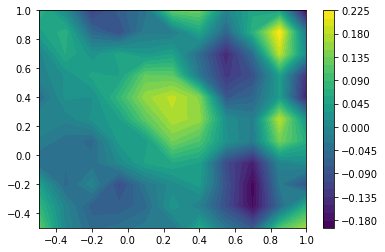

In [84]:
n = 11
np.random.seed(0)
x1 = np.sort(np.linspace(-0.5, 1, n))
# x2 = np.sort(np.random.uniform(-0.5, 1, n))
X1, X2 = np.meshgrid(x1, x1)

def simulate(a, b):
    bi = np.pi * (2*a + 0.5*b + 1)
    return 0.1 * (np.sin(a*bi) + np.sin(b*bi))

y = np.array([simulate(a,b) for a,b in zip(X1.ravel(), X2.ravel())]).reshape(-1,1) + np.random.normal(0,0.025, n*n).reshape(-1,1)
X = np.array([(a,b) for a,b in zip(X1.ravel(), X2.ravel())])

plt.contourf(X1, X2, y.reshape(n, n), levels=30);
plt.colorbar();

print(X.shape, y.shape)

np.random.seed(0)
n = 31
x1_test = np.linspace(-0.5, 1, n)
X1_test, X2_test = np.meshgrid(x1_test, x1_test)

X_test = np.array([(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())])
y_test = np.array([simulate(a,b) for a,b in zip(X1_test.ravel(), X2_test.ravel())]).reshape(-1,1)
print(X_test.shape, y_test.shape)

In [85]:
for seed in [2,3,4,5]:
    model = NSGPRegression(X, y, num_inducing_points=3, seed=seed)
    model.optimize(iters=100, lr=0.1)
    pred_y = model.predict(X_test)[0].numpy()
    plt.contourf(X1_test, X2_test, pred_y.reshape(n,n), levels=30)
    plt.scatter(model.X_bar[:,0], model.X_bar[:,1])
    plt.colorbar()

    print(np.mean(np.square(y_test-pred_y))/np.var(y_test))
#     model.vs.print()

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'logpdf'

In [72]:
model.vs.print()
model.vs['global_std']**2

local_std:  2.821
local_gp_ls0: 1.061
local_gp_noise0: 0.5129
local_ls0:
    [[0.84753991]
     [1.59473408]
     [4.13436443]]
local_gp_ls1: 0.9627
local_gp_noise1: 0.8393
local_ls1:
    [[1.28300333]
     [3.46361145]
     [1.35718658]]
global_std: 0.2335
global_noise: 0.07029


<tf.Tensor: shape=(), dtype=float64, numpy=0.05453996854556822>

In [73]:
m = GPy.models.GPRegression(X, y, GPy.kern.RBF(2, ARD=True), normalizer=False)
m.optimize_restarts(10, verbose=False);
# m.plot()
# print(m)
# m.kern.lengthscale, m['Gaussian_noise.variance']**.5
pred_y = m.predict(X_test)[0]
print(np.mean(np.square(y_test-pred_y))/np.var(y_test))
m, m.kern.lengthscale

0.056334855298492144


(<GPy.models.gp_regression.GPRegression at 0x7ff640671f70>,
 GP_regression.rbf.lengthscale:
 Param([0.16535625, 0.23951609]))

### Data 1(Sin mix)

In [ ]:
np.random.seed(0)
X = np.linspace(-1,1,100).reshape(-1,1)
# y = np.sin(10*X) + np.random.normal(0,0.1,100).reshape(-1,1)
y = np.sin(-np.abs(7*X)) + np.random.normal(0,0.1,100).reshape(-1,1)

X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

plt.scatter(X_scaled, y_scaled);

In [ ]:
model = fit_predict_plot(X_scaled, y_scaled)

### Data2 (Olymplic marathon)

In [ ]:
import pods

data = pods.datasets.olympic_marathon_men()
X = data['X']
y = data['Y']

plt.scatter(X, y);

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 3 (della_gatta_gene data)

### Helper function

In [16]:
def fit_predict_plot(X, y):
    ## Stationary fit
    m = GPy.models.GPRegression(X, y, GPy.kern.RBF(X.shape[1]))
    m.optimize_restarts(5, verbose=False)
    
    pred_y, var_y = m.predict(X)
    pred_y = pred_y.ravel()
    std2_y = np.sqrt(var_y.ravel())*2

    fig, ax = plt.subplots(1,2,figsize=(12,3))
    ax[0].set_title('Stationary GP')
    ax[0].scatter(X, y, label='data')
    ax[0].plot(X, pred_y, label='pred_mean')
    ax[0].fill_between(X[:,0], pred_y.ravel()-std2_y, pred_y.ravel()+std2_y, alpha=0.3, label='95% conf')
    ax[0].set_xlabel('X'); ax[0].set_ylabel('y')
    ax[0].legend()
    
    ax[1].plot(X.ravel(), [m.kern.lengthscale]*len(y))
    ax[1].set_xlabel('X'); ax[1].set_ylabel('Lenghtscale');
    
    n_list = list(range(1, 11))
#     n_list = [5]
    n_restarts = 5
    obj_list = []
    best_models = []
    for n in n_list:
        best_loss = np.inf
        best_model = None
        for seed in range(n_restarts):
            clear_output(wait=True)
            print('n',n,'seed',seed)
            model = NSGPRegression(X, y, num_inducing_points=n, seed=seed)
            model.optimize()
            if model.GlobalGP(model.vs)<best_loss:
                best_loss = model.GlobalGP(model.vs)
                best_model = model
        
        obj_list.append(best_loss)
        best_models.append(best_model)
    
    X_new = np.linspace(X.min(), X.max(), 201).reshape(-1,1)
    for bi, best_model in zip(n_list, best_models):
        pred_y, var_y = best_model.predict(X_new)
        pred_y = pred_y.numpy()
        std2_y = np.sqrt(var_y.numpy().diagonal())*2
        
        fig, ax = plt.subplots(1,2,figsize=(12,3))
        ax[0].set_title('num_inducing_points = '+str(bi))
        ax[0].scatter(X, y, label='data')
        ax[0].plot(X_new, pred_y, label='pred_mean')
        ax[0].fill_between(X_new[:,0], pred_y.ravel()-std2_y, pred_y.ravel()+std2_y, alpha=0.3, label='95% conf')
        ax[0].set_xlabel('X'); ax[0].set_ylabel('y')
        ax[0].legend()

        ax[1].plot(X.ravel(), [m.kern.lengthscale]*len(y), label='Stat. LS')
        ax[1].plot(X_new.ravel(), np.array(best_model.LocalGP(best_model.vs, X_new)).ravel())
        ax[1].scatter(best_model.X_bar, best_model.vs['local_ls0']);
        ax[1].set_xlabel('X'); ax[1].set_ylabel('Lenghtscale');
        ax[1].legend()
    df = pd.DataFrame(np.vstack([n_list, obj_list]).T, columns=['n_inducing_points', 'Loss (nlml)'])
    plt.figure()
    plt.plot(df.n_inducing_points, df['Loss (nlml)'])
    plt.xlabel('num_inducing_points')
    plt.ylabel('Loss')
    plt.title('Num_inducing_points vs Loss')

In [ ]:
data = pods.datasets.della_gatta_TRP63_gene_expression(data_set='della_gatta',gene_number=937)

X = data['X']
y = data['Y']

plt.scatter(X, y);

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

###  Data 4 (Step function overlap in between)

In [ ]:
num_low=25
num_high=25
gap = -.1
noise=0.0001
X = np.vstack((np.linspace(-1, -gap/2.0, num_low)[:, np.newaxis],
              np.linspace(gap/2.0, 1, num_high)[:, np.newaxis]))
y = np.vstack((np.zeros((num_low, 1)), np.ones((num_high,1))))

plt.scatter(X, y);

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 5 (Motorcycle helmet dataset)

In [ ]:
data = pd.read_csv('../../../motor.csv')
print(data.columns)
X = data['times'].values.reshape(-1,1)
y = data['accel'].values.reshape(-1,1)

plt.scatter(X, y);

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)

### Data 6 (Smooth-1D used by plagemann)

In [ ]:
np.random.seed(0)
X = np.linspace(-2, 2, 101).reshape(-1,1)
y = np.sin(X) + 2 * np.exp(-30*X**2) + np.random.normal(0,0.3,101).reshape(-1,1)

plt.scatter(X, y);

In [ ]:
X_scaled = StandardScaler().fit_transform(X)
y_scaled = StandardScaler().fit_transform(y)

fit_predict_plot(X_scaled, y_scaled)